# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#df = pd.read_csv('real_estate_data.csv', sep ='\t')
#df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
try:
    df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


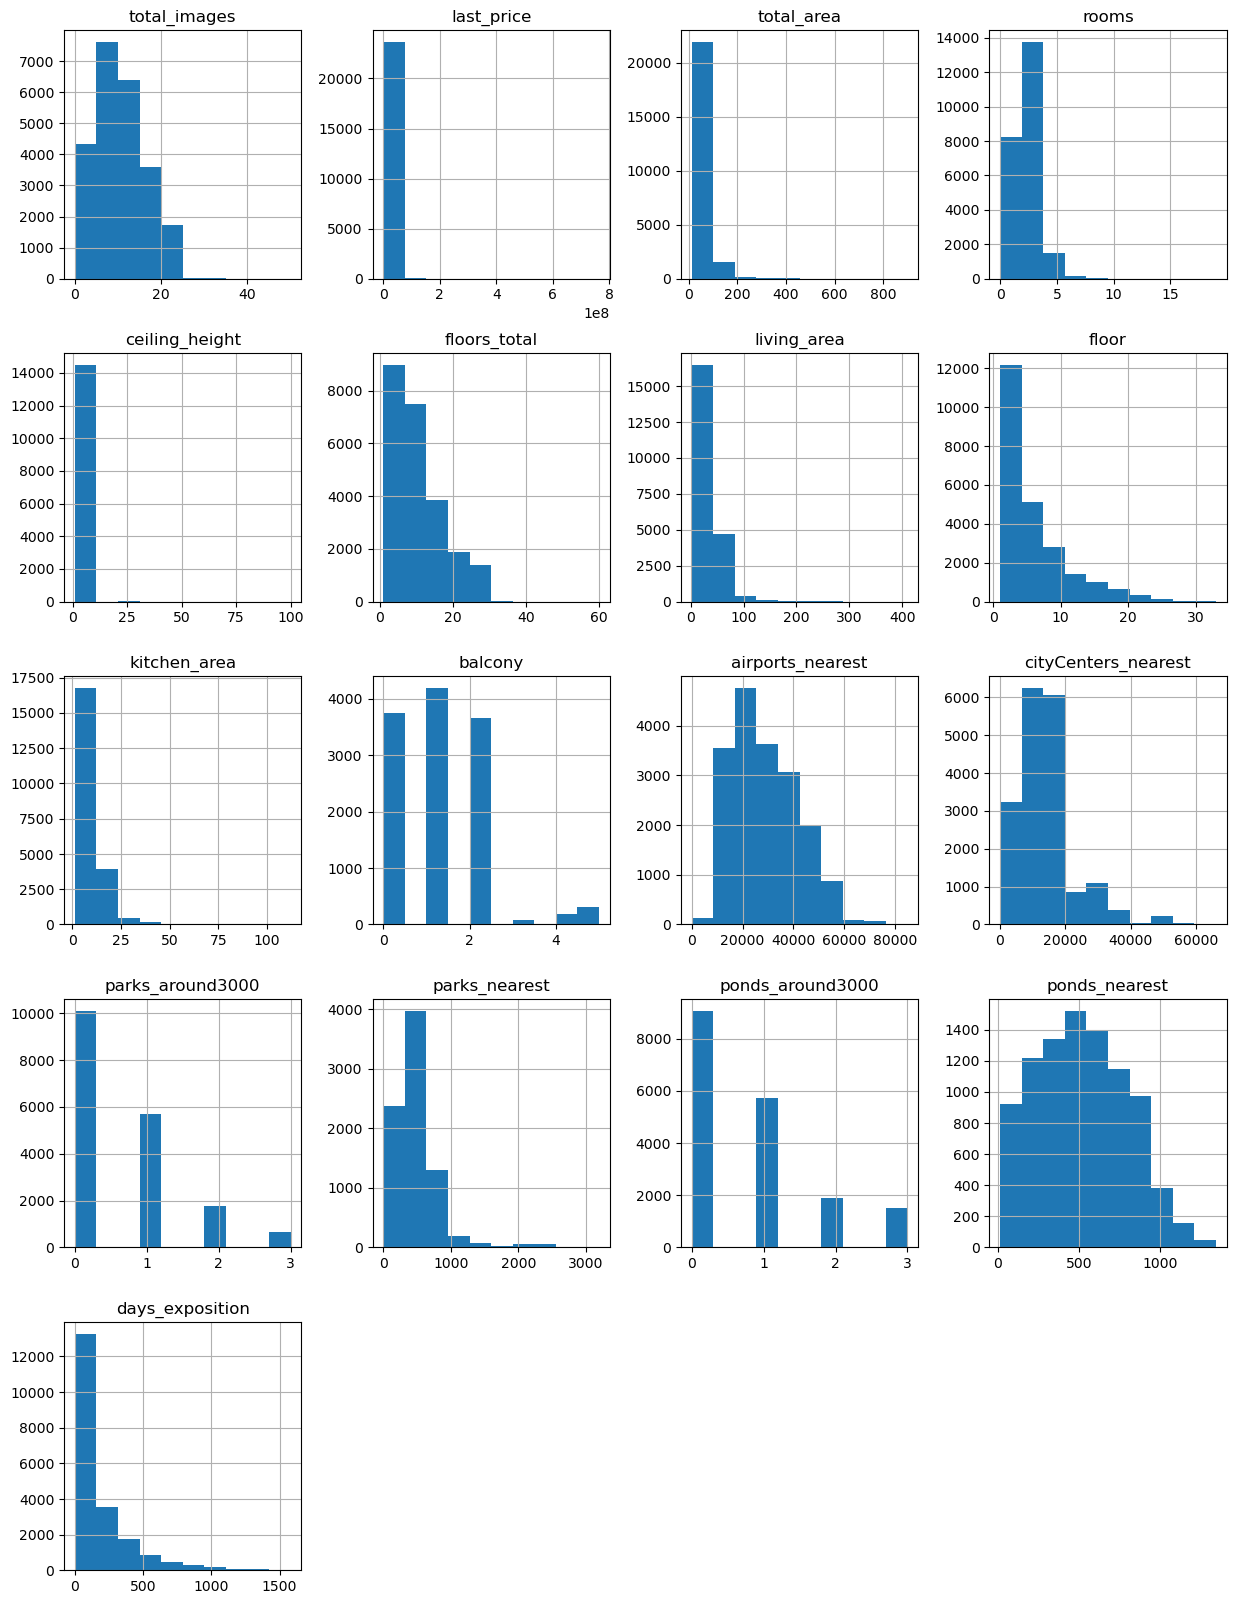

In [29]:
df.hist(figsize=(15, 20));
plt.show()

### Предобработка данных

In [30]:
df.isna().sum()
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,88.000000


Комбинацией двух методов нашли количество пропусков в столбцах

**Балконы**

В таблице "балконы" пропуски, скорее всего, подразумевают отсутсвие балкона в квартире, поэтому заменим пропуски 0

In [31]:
df['balcony'] = df['balcony'].fillna(0)

C балконами проблема решена

**Количество этажей**

In [32]:
df['floors_total'].unique()

array([16., 11.,  5., 14., 12., 26., 24., 27.,  9.,  6., 17., 25.,  3.,
       23., 19., 18.,  4., 22.,  8.,  2., 10.,  7., 13., 15., nan, 20.,
       28., 36., 21., 35., 34., 60.,  1., 29., 33., 52., 37.])

In [33]:
df['floors_total'].dropna(inplace=True)

In [34]:
df['floors_total'] =  df['floors_total'].astype('Int8')

Пропуски разумно заполнить медианным значением. Также значения были дробными, что в принципе быть не должно, поэтому заменил на целые числа

**Дни публикации**

In [35]:
df['days_exposition'] = np.floor(pd.to_numeric(df['days_exposition'], errors='coerce')).astype('Int64')

**Высота потолков**

In [36]:
df['ceiling_height'].unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

In [37]:
df.loc[(df['ceiling_height'] > 23.9) & (df['ceiling_height'] < 50), 'ceiling_height'] = \
df['ceiling_height'] / 10

В столбце с высотой потолков очень много пропусков, если заменять медианным значением, то статистика испортится, поэтому, думаю, что нужно просто убрать аномальные значения

**Жилая зона**

In [38]:
df['living_area'].unique()

array([51.  , 18.6 , 34.3 , ..., 31.65, 13.59, 42.55])

**Аппартаменты**

In [39]:
df['is_apartment'].unique()
df['is_apartment'] = df['is_apartment'].fillna(False)

Пропуски в столбце с апартаментами нельзя заменять медианными значениями и другими, потому что это булева значения. Данные пропуски заменим False.


**Кухонная зона**

In [40]:
df['kitchen_area'].unique()

array([ 25.  ,  11.  ,   8.3 ,    nan,  41.  ,   9.1 ,  14.4 ,  18.9 ,
         8.81,   6.5 ,   8.5 ,   6.  ,   9.  ,   5.2 ,   8.  ,   7.6 ,
         5.6 ,  12.  ,   5.7 ,   6.1 ,  19.6 ,  15.  ,   7.  ,   9.2 ,
        11.7 ,  13.4 ,  17.  ,   6.3 ,  11.6 ,   8.8 ,  10.  ,  17.6 ,
         7.5 ,   9.5 ,  50.  ,  15.5 ,  10.7 ,  11.1 ,  20.  ,  11.9 ,
        16.  ,   5.3 ,  11.5 ,   7.2 ,   6.2 ,  10.4 ,   7.1 ,   4.9 ,
         7.3 ,  11.95,  10.2 ,   6.4 ,   5.5 ,  13.  ,   8.4 ,  23.6 ,
        10.8 ,  18.3 ,   5.  ,   8.2 ,  24.  ,  23.8 ,   6.6 ,  26.85,
        15.4 ,   7.8 ,  33.8 ,   5.4 ,  12.72,  12.2 ,  19.  ,  12.4 ,
         7.9 ,  10.3 ,   9.8 ,  17.5 ,  14.7 ,  20.91,  21.3 ,  10.6 ,
        10.9 ,   9.7 ,   7.7 ,  12.5 ,  11.4 ,   8.6 ,  11.24,  14.1 ,
        15.7 ,  13.29,  14.  ,  12.9 ,  12.7 ,  16.5 ,   9.36,  21.5 ,
        35.  ,  10.5 ,   8.7 ,  19.3 ,  21.4 ,  40.  ,  49.2 ,  11.52,
         8.9 ,   9.6 ,  30.  ,  14.2 ,   8.1 ,  10.44,   4.5 ,  16.3 ,
      

Оставим Null

Существуют квартиры без кухни, поэтому пропуски можно заполнить нулями

**Наименования**

In [41]:
df['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Заменим "ё" на "е", чтобы не было дубликатов. Также "заменим городской поселок" на "поселок городского типа"

In [42]:
df['locality_name'] = df['locality_name'].str.replace('посёлок', 'поселок') 
df['locality_name'] = df['locality_name'].str.replace('городской поселок','поселок городского типа')
df['locality_name'].dropna(inplace=True)

**Близость к центру города**

Приведем названия столбца к нижнему регистру

In [43]:
df = df.rename(columns = {'cityCenters_nearest': 'citycenters_nearest'})

Ситуация аналогична с аэропортами.

In [44]:
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,0.000000


**Отсутвие пропусков в остальных столбцах не поможет сделать вывод проекта**

Переведем столбец first_day_exposition в формат даты

In [45]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'])

**Уберем аномальные значения**

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  Int8          
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

In [47]:
df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,citycenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,23699.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.738456,10.673824,34.457852,5.892358,10.569807,0.591080,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,0.893702,6.597173,22.030445,4.885249,5.905438,0.959298,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.510000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,0.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,1.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


**Цена квартир**

In [48]:
print('Квартир стоимостью 0:', df.query('last_price == 0')['last_price'].count())
print('Квартир стоимостью меньше 100.000:', df.query('last_price < 1e+05')['last_price'].count())
print('Квартир стоимостью больше 100.000.000:', df.query('last_price > 1e+08')['last_price'].count())

print('Квартир стоимостью больше 100.000.000:', df.query('last_price > 1e+08')['last_price'].count())
df.drop(index=df.query('last_price > 1e+08').index,inplace=True)
df.info()

Квартир стоимостью 0: 0
Квартир стоимостью меньше 100.000: 1
Квартир стоимостью больше 100.000.000: 37
Квартир стоимостью больше 100.000.000: 37
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23662 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23662 non-null  int64         
 1   last_price            23662 non-null  float64       
 2   total_area            23662 non-null  float64       
 3   first_day_exposition  23662 non-null  datetime64[ns]
 4   rooms                 23662 non-null  int64         
 5   ceiling_height        14479 non-null  float64       
 6   floors_total          23576 non-null  Int8          
 7   living_area           21764 non-null  float64       
 8   floor                 23662 non-null  int64         
 9   is_apartment          23662 non-null  bool          
 10  studio                23662 non-null  bool   

Убираем квартиры, которые стоят больше 100.000.000

Text(0.5, 1.0, 'last_price')

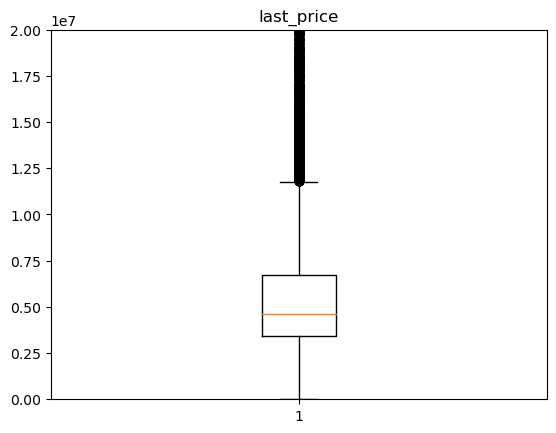

In [49]:
plt.ylim(0,2e+07)
#df.hist('last_price', bins=50, range=(0,2e+07))
#df.hist('last_price', bins=50, range=(0,4e+06))
plt.boxplot(df['last_price'])
plt.title('last_price')
#df.drop(index=df.query('last_price < 1e+05').index,inplace=True)

На графиках нет выбросов. Оставляем

**Общая площадь квартиры**

Минимальный размер квартиры 12 м^2. Присутсвуют квартиры общей площадью 900 м^2. Похоже это элитная недвижимость. Нужно удалить.

In [50]:
print('Квартир площадью менее 10 м^2:',df.query('total_area < 10')['total_area'].count()) 
print('Квартир площадью более 500 м^2:',df.query('total_area > 500')['total_area'].count())

Квартир площадью менее 10 м^2: 0
Квартир площадью более 500 м^2: 3


In [51]:
df.drop(index=df.query('total_area > 500').index,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23659 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23659 non-null  int64         
 1   last_price            23659 non-null  float64       
 2   total_area            23659 non-null  float64       
 3   first_day_exposition  23659 non-null  datetime64[ns]
 4   rooms                 23659 non-null  int64         
 5   ceiling_height        14477 non-null  float64       
 6   floors_total          23573 non-null  Int8          
 7   living_area           21761 non-null  float64       
 8   floor                 23659 non-null  int64         
 9   is_apartment          23659 non-null  bool          
 10  studio                23659 non-null  bool          
 11  open_plan             23659 non-null  bool          
 12  kitchen_area          21387 non-null  float64       
 13  balcony         

array([[<AxesSubplot:title={'center':'total_area'}>]], dtype=object)

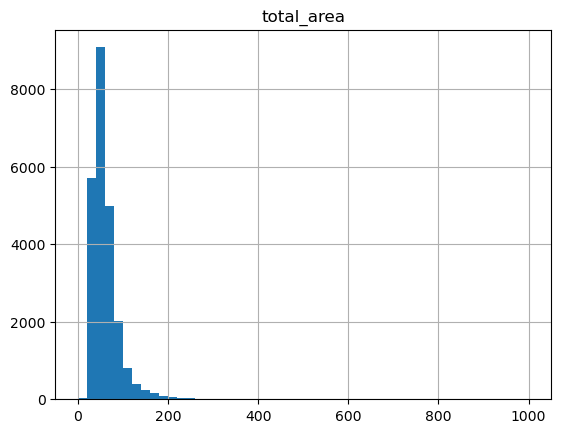

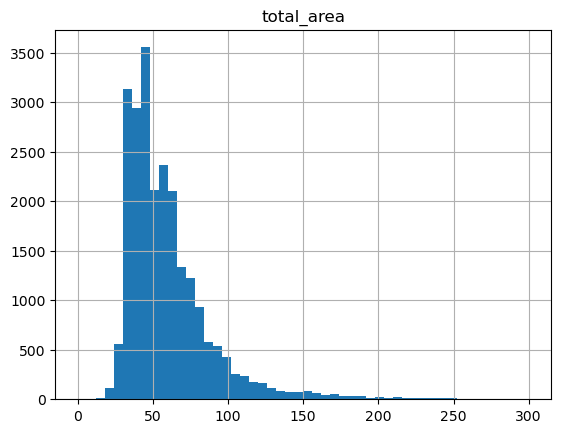

In [52]:
df.hist('total_area', bins=50, range=(0,1000))
df.hist('total_area', bins=50, range=(0,300))

**Комнаты**

Минимальное значение комнат в квартире - 0, максимальное - 19

In [53]:
print('Квартиры без комнат:',df.query('rooms == 0')['rooms'].count())
print('Квартиры без комнат и студии:',df.query('rooms == 0 and studio')['rooms'].count()) 
print('Квартиры без комнат и апартаменты:',df.query('rooms == 0 and is_apartment')['rooms'].count()) 
print('Квартиры без комнат и свободная планировка:',df.query('rooms == 0 and open_plan')['rooms'].count())
print('Квартиры без комнат не апартаменты и не свободная планировка:',df.query('rooms == 0 and ~open_plan and ~studio')['rooms'].count())
df.drop(index=df.query('rooms > 7').index,inplace=True)
df.info()

Квартиры без комнат: 197
Квартиры без комнат и студии: 138
Квартиры без комнат и апартаменты: 0
Квартиры без комнат и свободная планировка: 59
Квартиры без комнат не апартаменты и не свободная планировка: 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23632 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23632 non-null  int64         
 1   last_price            23632 non-null  float64       
 2   total_area            23632 non-null  float64       
 3   first_day_exposition  23632 non-null  datetime64[ns]
 4   rooms                 23632 non-null  int64         
 5   ceiling_height        14458 non-null  float64       
 6   floors_total          23546 non-null  Int8          
 7   living_area           21735 non-null  float64       
 8   floor                 23632 non-null  int64         
 9   is_apartment          23632 non-null  boo

**Количество этажей в доме**

In [54]:
print('Квартир в одноэтажных домах : ',df.query('floors_total == 1')['floors_total'].count())
print('Квартир в 30+ этажных домах : ',df.query('floors_total > 30')['floors_total'].count())

ValueError: unknown type object

In [55]:
df.drop(index=df.query('floors_total > 30').index,inplace=True)
df.info()

ValueError: unknown type object

array([[<AxesSubplot:title={'center':'floors_total'}>]], dtype=object)

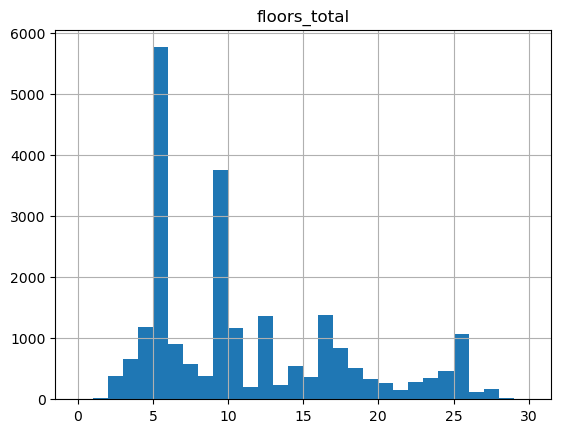

In [56]:
df.hist('floors_total', bins=30,range=(0,30))

**Высота потолков**

Возьмем за минимальную высоту - 2.2м, поэтому квартиры с потолками ниже нормы удаляем.
Также удаляем квартиры с высотой потолков от 4 до 25метров.
Для квартир с высотой потолков до 25 до 36 метров предполагаем, что это опечатка и делим на 10, получая 2.5 и 3.6 метра.
Удаляем квартиры с высотой потолков от 36 метров.

In [57]:
print('Квартир с потолками меньше 2.2м :', df.query('ceiling_height < 2.2')['ceiling_height'].count())
df.drop(index=df.query('ceiling_height < 2.2').index,inplace=True)
df.drop(index=df.query('ceiling_height > 4 and ceiling_height < 25').index,inplace=True)
df.drop(index=df.query('ceiling_height > 36').index,inplace=True)
df.info()

Квартир с потолками меньше 2.2м : 14
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23568 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23568 non-null  int64         
 1   last_price            23568 non-null  float64       
 2   total_area            23568 non-null  float64       
 3   first_day_exposition  23568 non-null  datetime64[ns]
 4   rooms                 23568 non-null  int64         
 5   ceiling_height        14394 non-null  float64       
 6   floors_total          23482 non-null  Int8          
 7   living_area           21679 non-null  float64       
 8   floor                 23568 non-null  int64         
 9   is_apartment          23568 non-null  bool          
 10  studio                23568 non-null  bool          
 11  open_plan             23568 non-null  bool          
 12  kitchen_area          21310 non-null 

array([[<AxesSubplot:title={'center':'ceiling_height'}>]], dtype=object)

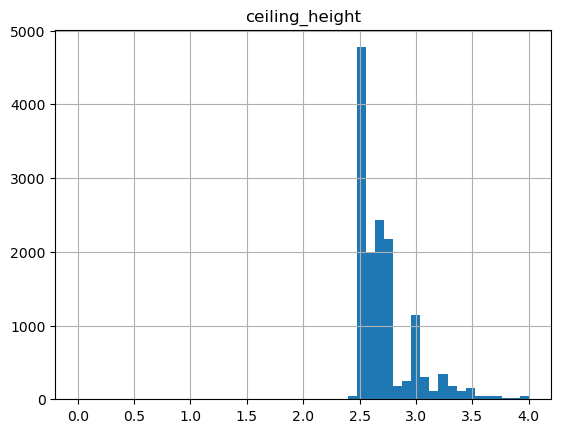

In [58]:
df.hist('ceiling_height',bins=50,range=(0,4))

**Жилая площадь квартиры**

Жилая площадь в 2 м^2 явно выбивается из всей выборки. Минимальная жилая площадь на человека по СНиПу - 10 м, поэтому разумно убрать квартиры, которые не соотвуствуют этому параметру. Также уберем жилые площади свыше 200 м^2.

In [59]:
print('Жилая площадь меньше 10 м^2:',df.query('living_area < 10')['living_area'].count())
print('Жилая площадь больше общей:',df.query('living_area > total_area')['living_area'].count())
print('Жилая площадь больше 200 м^2:',df.query('living_area > 200')['living_area'].count())

Жилая площадь меньше 10 м^2: 25
Жилая площадь больше общей: 0
Жилая площадь больше 200 м^2: 12


In [60]:
df.drop(index=df.query('living_area < 10').index,inplace=True)
df.drop(index=df.query('living_area > 200').index,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23531 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23531 non-null  int64         
 1   last_price            23531 non-null  float64       
 2   total_area            23531 non-null  float64       
 3   first_day_exposition  23531 non-null  datetime64[ns]
 4   rooms                 23531 non-null  int64         
 5   ceiling_height        14368 non-null  float64       
 6   floors_total          23445 non-null  Int8          
 7   living_area           21642 non-null  float64       
 8   floor                 23531 non-null  int64         
 9   is_apartment          23531 non-null  bool          
 10  studio                23531 non-null  bool          
 11  open_plan             23531 non-null  bool          
 12  kitchen_area          21276 non-null  float64       
 13  balcony         

array([[<AxesSubplot:title={'center':'living_area'}>]], dtype=object)

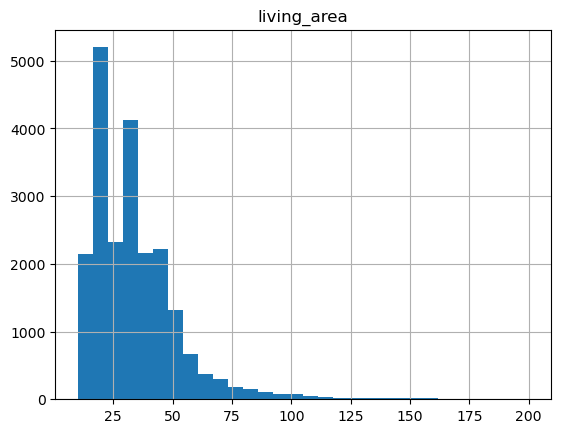

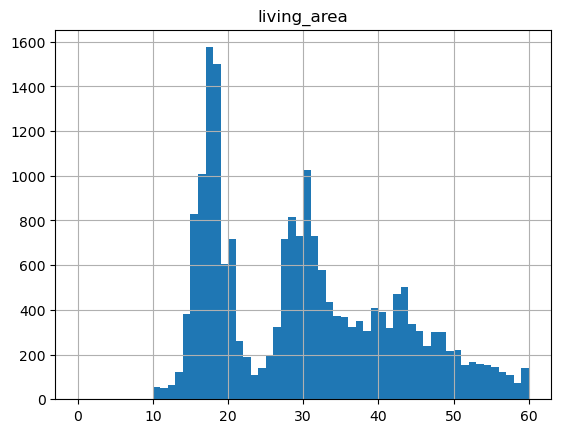

In [61]:
df.hist('living_area', bins=30)
df.hist('living_area', bins=60, range=(0,60))

**Этаж**

Здесь нет выбросов. Единственное что может быть - несоотвествие этажу квартиры и этажей во всем доме

In [62]:
df['floor_category'] = df.apply(
    lambda x: 'первый' if (x.floor == 1) 
    else ('последний' if (x.floor == x.floors_total) & isinstance(x.floors_total,int) 
    else 'другой'), axis=1
)

<div class="alert alert-info"> <b>Комментарии студента:</b> Исправил </div>

array([[<AxesSubplot:title={'center':'floor'}>]], dtype=object)

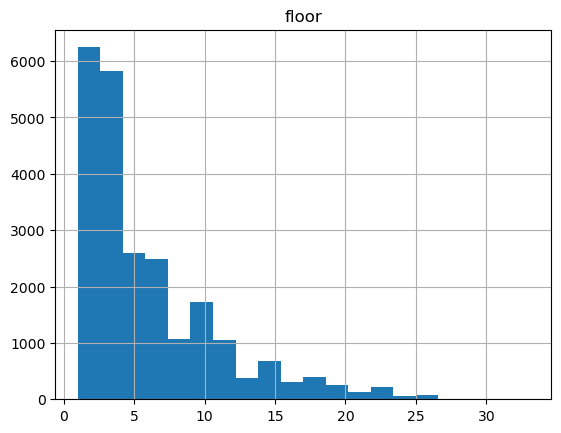

In [63]:
df.hist('floor',bins=20)

**Зона кухни**

Существуют квартиры где кухонная зона очень маленькая. Квартиры с площадью кухни боль 50 м^2 мало

In [64]:
print('Площадь кухни меньше 2 м^2: ',df.query('kitchen_area < 2')['living_area'].count())
print('Площадь кухни больше 50 м^2: ',df.query('kitchen_area > 50')['living_area'].count())
print('Площадь кухни больше общей: ',df.query('kitchen_area > total_area')['living_area'].count())

Площадь кухни меньше 2 м^2:  1
Площадь кухни больше 50 м^2:  33
Площадь кухни больше общей:  0


In [65]:
df.drop(index=df.query('kitchen_area > 50').index,inplace=True)
df.drop(index=df.query('kitchen_area < 2').index,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23496 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23496 non-null  int64         
 1   last_price            23496 non-null  float64       
 2   total_area            23496 non-null  float64       
 3   first_day_exposition  23496 non-null  datetime64[ns]
 4   rooms                 23496 non-null  int64         
 5   ceiling_height        14343 non-null  float64       
 6   floors_total          23410 non-null  Int8          
 7   living_area           21608 non-null  float64       
 8   floor                 23496 non-null  int64         
 9   is_apartment          23496 non-null  bool          
 10  studio                23496 non-null  bool          
 11  open_plan             23496 non-null  bool          
 12  kitchen_area          21241 non-null  float64       
 13  balcony         

array([[<AxesSubplot:title={'center':'kitchen_area'}>]], dtype=object)

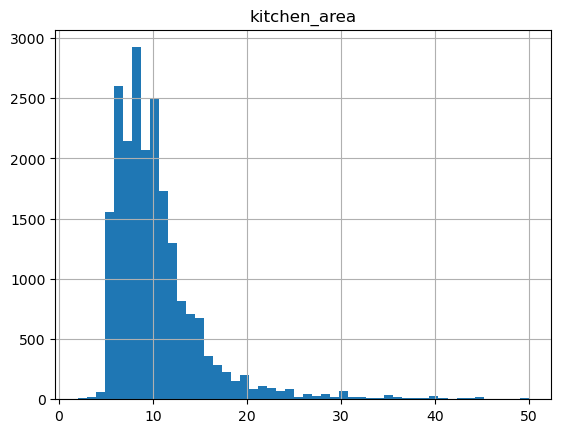

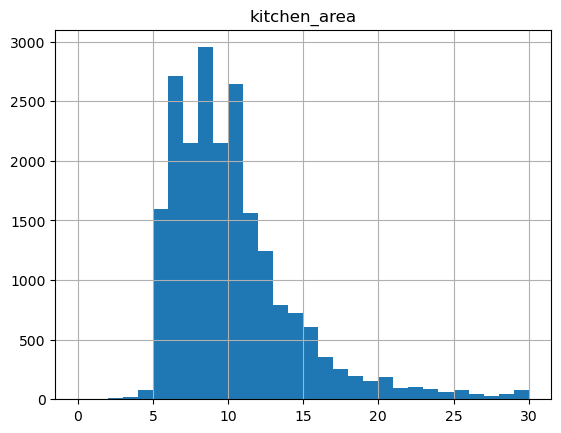

In [66]:
df.hist('kitchen_area', bins=50)
df.hist('kitchen_area', bins=30, range=(0,30))

**Количество дней когда объявление было актуально**

В целом график нормальный, единственное это объявления, которые слишком давно были опубликованы

In [67]:
print('Объявление не было оопубликовано: ',df.query('days_exposition == 0')['days_exposition'].count())

print('Объявлению больше 3 лет : ',df.query('days_exposition > 365*3')['days_exposition'].count())

df.drop(index=df.query('days_exposition > 365*3').index,inplace=True)

df.hist('days_exposition', bins=100);
df.info()

ValueError: unknown type object

In [ ]:
df.drop(index=df.query('days_exposition > 365*3').index,inplace=True)
df.info()

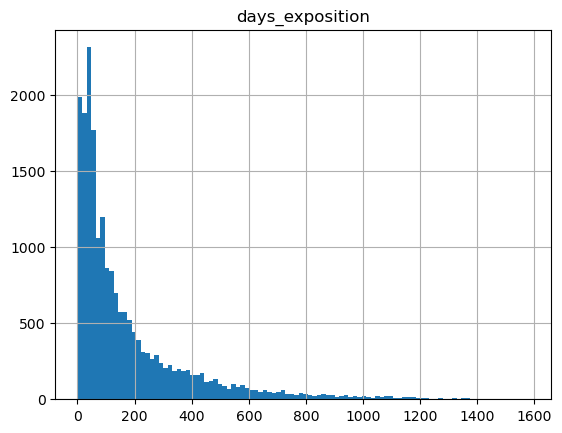

In [68]:
df.hist('days_exposition', bins=100);

**Близость к аэропорту**

Только одна квартира находится слишком близко к аэропорту. Уберем ее

In [69]:
print('Квартир слишком близко к аэропорту:',df.query('airports_nearest < 5000')['airports_nearest'].count())

Квартир слишком близко к аэропорту: 1


In [70]:
df.drop(index=df.query('airports_nearest < 5000').index,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23495 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23495 non-null  int64         
 1   last_price            23495 non-null  float64       
 2   total_area            23495 non-null  float64       
 3   first_day_exposition  23495 non-null  datetime64[ns]
 4   rooms                 23495 non-null  int64         
 5   ceiling_height        14342 non-null  float64       
 6   floors_total          23409 non-null  Int8          
 7   living_area           21607 non-null  float64       
 8   floor                 23495 non-null  int64         
 9   is_apartment          23495 non-null  bool          
 10  studio                23495 non-null  bool          
 11  open_plan             23495 non-null  bool          
 12  kitchen_area          21240 non-null  float64       
 13  balcony         

array([[<AxesSubplot:title={'center':'airports_nearest'}>]], dtype=object)

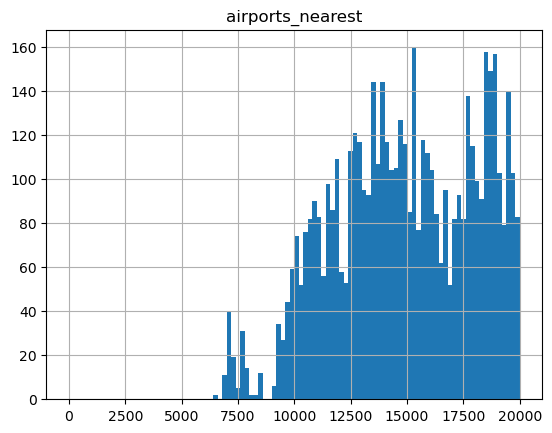

In [71]:
df.hist('airports_nearest', bins=100, range=(0,20000))

Сбросим индексы после удаления строк

In [72]:
df.reset_index(drop=True,inplace=True)

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23495 entries, 0 to 23494
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23495 non-null  int64         
 1   last_price            23495 non-null  float64       
 2   total_area            23495 non-null  float64       
 3   first_day_exposition  23495 non-null  datetime64[ns]
 4   rooms                 23495 non-null  int64         
 5   ceiling_height        14342 non-null  float64       
 6   floors_total          23409 non-null  Int8          
 7   living_area           21607 non-null  float64       
 8   floor                 23495 non-null  int64         
 9   is_apartment          23495 non-null  bool          
 10  studio                23495 non-null  bool          
 11  open_plan             23495 non-null  bool          
 12  kitchen_area          21240 non-null  float64       
 13  balcony         

In [74]:
df['balcony'] = np.floor(pd.to_numeric(df['balcony'], errors='coerce')).astype('Int64')

In [75]:
df['last_price'] = np.floor(pd.to_numeric(df['last_price'], errors='coerce')).astype('Int64')

In [76]:
df.duplicated().sum()
df = df.drop_duplicates()

**Вывод**
<br />
Качесто исходных данных среднее. Чтобы верно интерпритировать графики и их зависимости нужно выполнить предобработку данных. К счастью, неявных дубликатов оказалось немного, поэтому это значительно ускорило процесс предобработки. Также присутвуют выбросы от которых необходимо избавится, чтобы верно трактовать графики, корреляции и зависимости.

### Посчитайте и добавьте в таблицу новые столбцы

In [77]:
df['price_per_sqm'] = df['last_price'] / df['total_area']

In [78]:
df['dayofweek'] = df['first_day_exposition'].dt.dayofweek

In [79]:
df['month'] = df['first_day_exposition'].dt.month

In [80]:
df['year'] = df['first_day_exposition'].dt.year

Присваиваем этажам квартиры категории

In [81]:
df['floor_category'] = df.apply(
    lambda x: 'первый' if (x.floor == 1) 
    else ('последний' if (x.floor == x.floors_total) & isinstance(x.floors_total,int) 
    else 'другой'), axis=1
)

In [82]:
df['floor_category'].value_counts()

другой       17316
последний     3279
первый        2900
Name: floor_category, dtype: int64

Растояние в километрах до центра города

In [83]:
df['citycenters_nearest_km'] = round(df['citycenters_nearest'] / 1000)

### Проведите исследовательский анализ данных

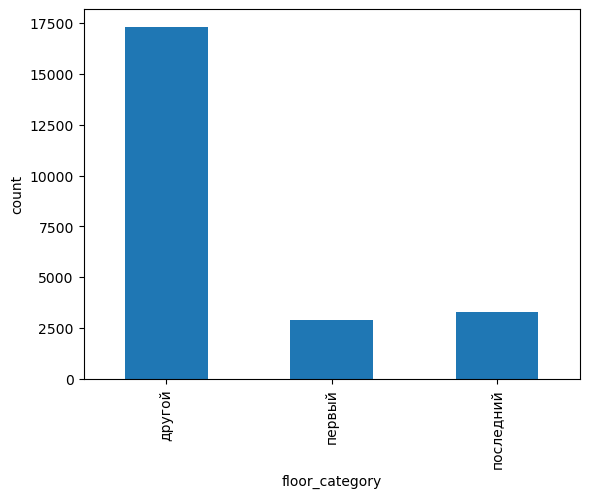

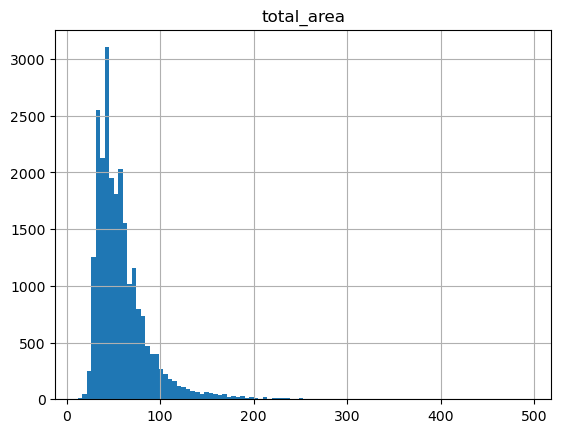

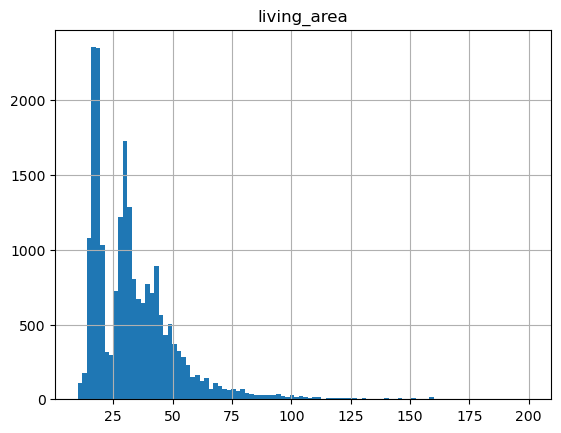

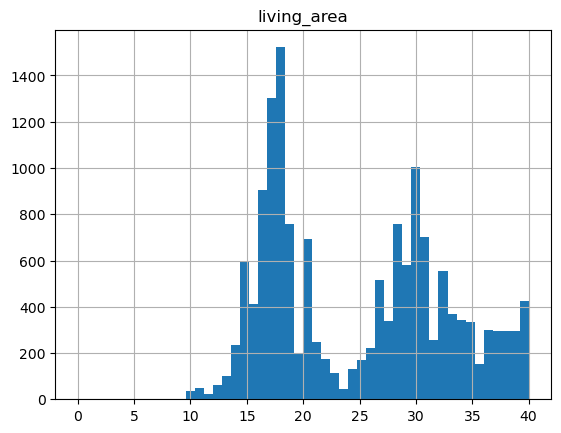

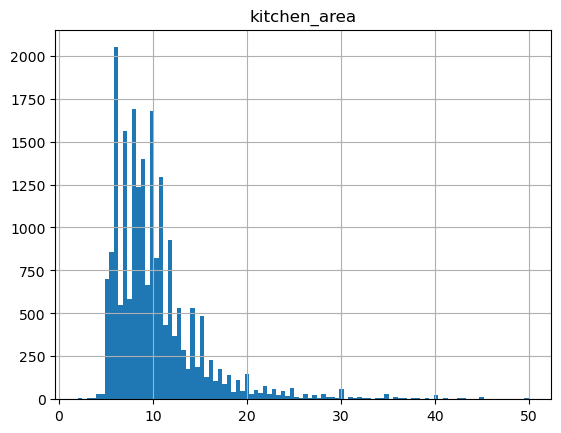

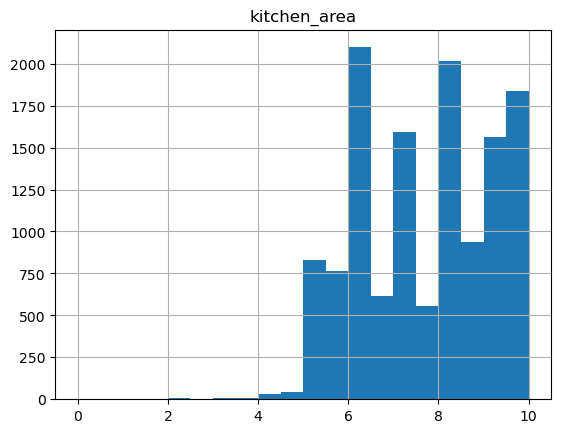

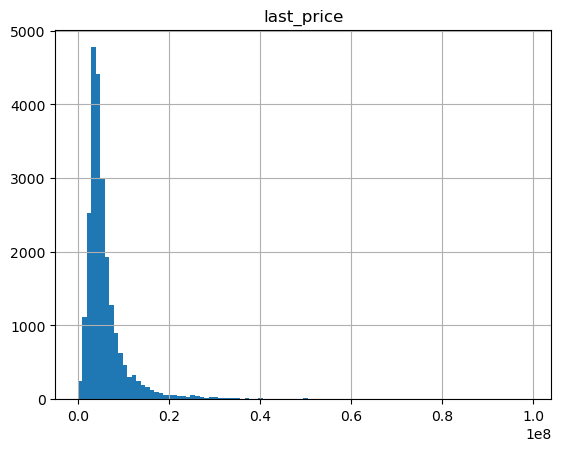

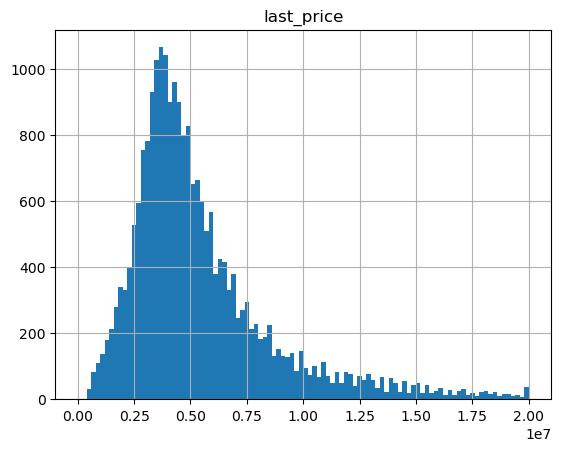

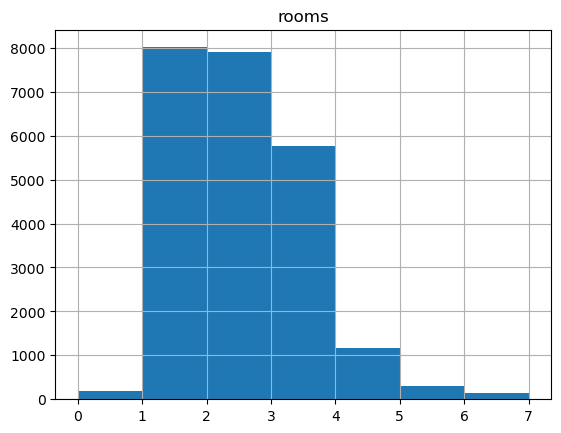

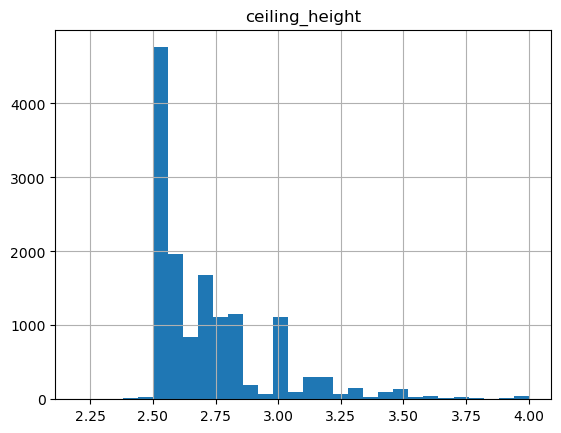

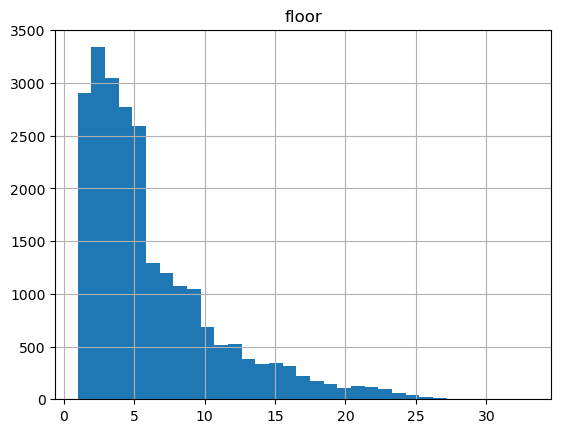

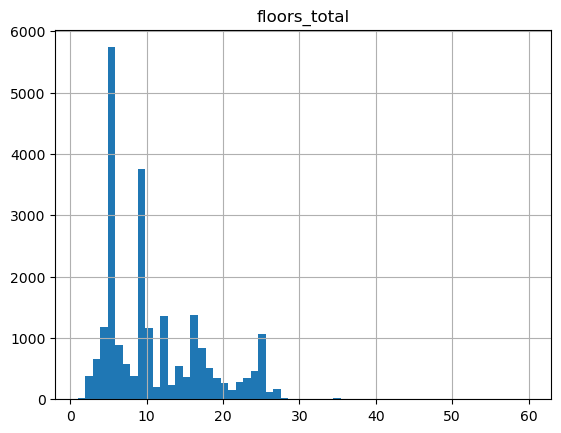

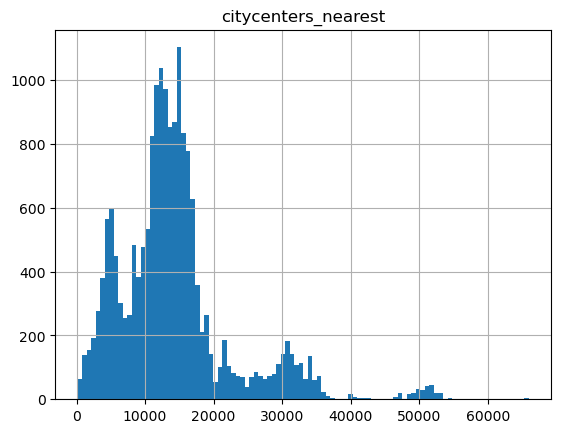

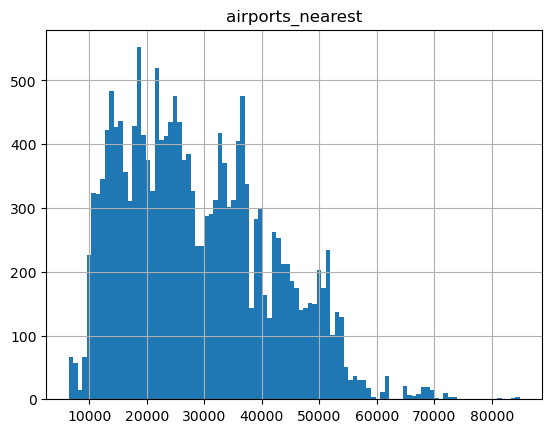

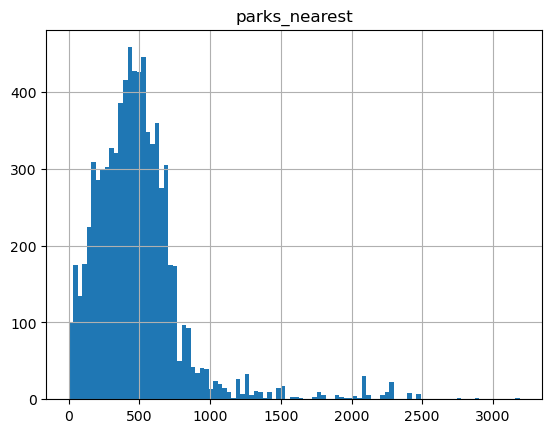

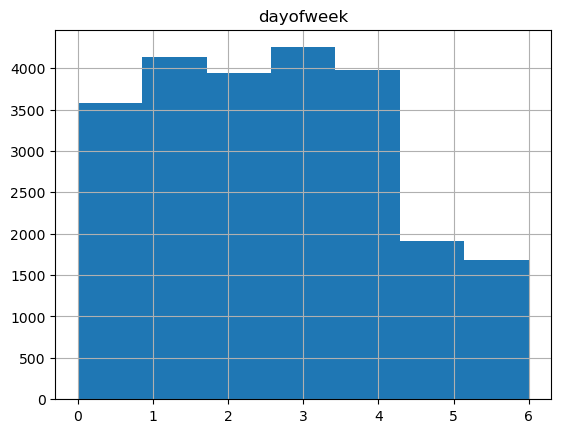

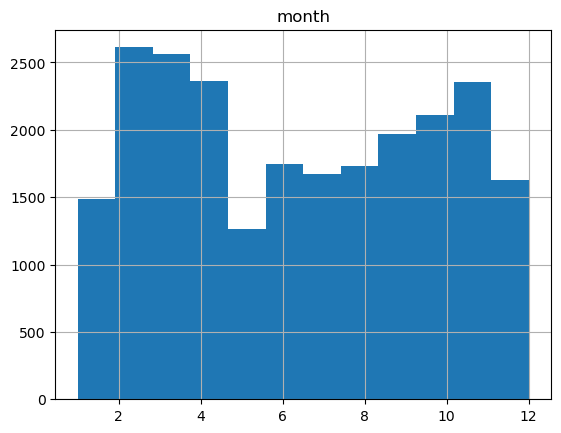

In [84]:
df.groupby(by='floor_category')['floor_category'].count().plot(kind='bar', ylabel = 'count');
df.hist('total_area', bins=100);
df.hist('living_area', bins=100);
df.hist('living_area', bins=50, range=(0,40));
df.hist('kitchen_area', bins=100);
df.hist('kitchen_area', bins=20, range=(0,10));
df.hist('last_price', bins=100);
df.hist('last_price', bins=100, range=(0,2e+07));
df.hist('rooms', bins=df['rooms'].max());
df.hist('ceiling_height', bins=30);
df.hist('floor', bins=df['floor'].max());
df.hist('floors_total', bins=df['floors_total'].max());
df.hist('citycenters_nearest', bins=100);
df.hist('airports_nearest', bins=100);
df.hist('parks_nearest', bins=100);
df.hist('dayofweek', bins=7);
df.hist('month', bins=12);

Построил графики для:

- Этажей. Логично, но в категории "другой" больше всего квартир. В оставшихся категориях одинаково мало квартир

- Общая площадь. На графике видно, что количество квартир снижается когда общая площадь начинает достигать 100 кв. метров. 

- Жилая зона. Присутвуют 2 пика: на 18 кв. метрах и 26 кв. метрах. Нужно понять почему такой резкий спад на 24 кв. метрах

- Кухонная зона. В целом график выглядит как нормальное распределение

- Цена квартиры. График нормальный, только очень длинный хвост в правой части. Это элитная недвижимость

- Комнаты. Больше всего квартир с 2-3 комнаты, на втором месте однокомнатные квартиры. Остальное - исключения.

- Высота потолков. Из-за большого количества пропусков график неудачный.

- Этаж. Больше всего квартир с 1-5 этаж, но это и логично, потому что болотистое основание Питера не позволяет строить небоскребы.

- Общее количество этажей в доме. Пик на 5 этажных домах и 9 этажных домах.

- Близость к центру города. Два основых пика: на 5км и 13-16 км. Дальше маленькие пики на 21 км и 31 км от центра города.

- Близость к аэропорту. Основной пик приходится на 25 км от аэропорта. Поменьше пики на 37 и 39 км от аэропорта.

 - Расстояние до ближайшего парка. Если судить по графику, то большинство квартир 400-700 метров от парков.

- День публикации. Меньше всего публикаций с 4-6 день недели

- Месяц публикации. С апреля до июля мы видим тендецию к понижению публикаций.

**Как быстро продавались квартиры**

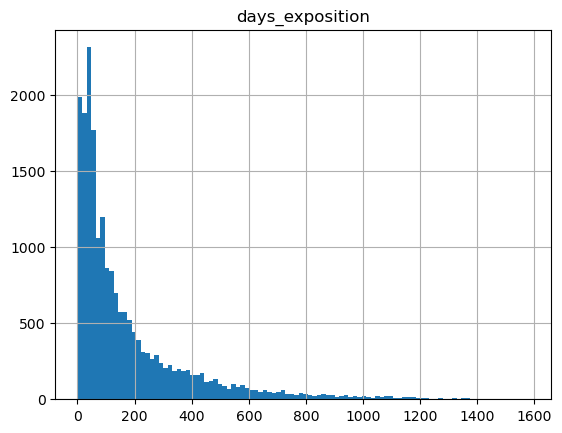

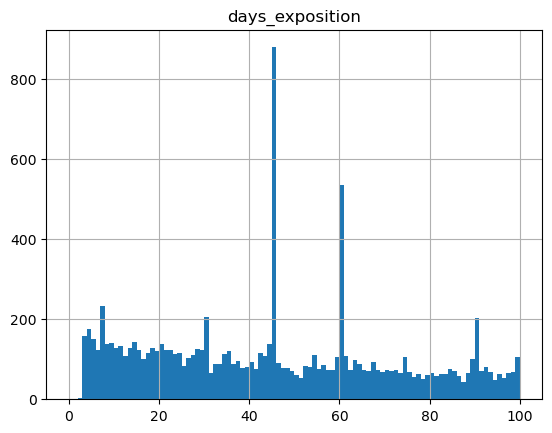

In [85]:
df.hist('days_exposition', bins=100);
df.hist('days_exposition', bins=100, range = (0,100));

In [86]:
print(f'Среднее время продажи квартиры в днях:',round(df['days_exposition'].mean()))
print('Медианное время продажи квартиры в днях:',round(df['days_exposition'].median()))

Среднее время продажи квартиры в днях: 180
Медианное время продажи квартиры в днях: 95


In [87]:
print('\n[Выбросы] Количество объявлений, которые сняты через:')
print('45 дней:',df[df['days_exposition'] == 45]['days_exposition'].count())
print('60 дней:',df[df['days_exposition'] == 60]['days_exposition'].count())
print('90 дней:',df[df['days_exposition'] == 90]['days_exposition'].count())


[Выбросы] Количество объявлений, которые сняты через:
45 дней: 878
60 дней: 535
90 дней: 202


Среднее время продажи составляет 195 дня, то есть пол года, а медианное 107 дней.

Я бы предложил считать быстрыми продажи до 107 дней, а необычно долгими - свыше 195 дня. Выбросы похожи на платные объявлени с истекшим сроком размещения или работу ситемы удаления неактивных объявлений.

In [88]:
df['days_exposition'].describe()

count    20348.000000
mean       180.092245
std        218.965662
min          1.000000
25%         45.000000
50%         95.000000
75%        230.000000
max       1580.000000
Name: days_exposition, dtype: float64

Среднее время продажи у нас составляет 183 дня, а медианное 105 дней. 
<br />
- Быстрыми продажами можно считать продажи, которые были совершены в течении 45 дней после публикации.
<br />
- Долгие продажи - продажи, которые совершенны после полугода (183 дня) с момента публикации.

In [89]:
df['last_price'] = df['last_price'].astype(int)

**Факторы которые влияют на стоимость**

In [90]:
list_for_graph = ['total_area',
                  'living_area',
                  'kitchen_area',
                  'rooms',
                  'dayofweek',
                  'month',
                  'year']

for entry in list_for_graph:
    correlation = df['last_price'].corr(df[entry])
    print(f'Корреляция между last_price и {entry} составляет: {correlation:0.2}')

Корреляция между last_price и total_area составляет: 0.76
Корреляция между last_price и living_area составляет: 0.67
Корреляция между last_price и kitchen_area составляет: 0.56
Корреляция между last_price и rooms составляет: 0.46
Корреляция между last_price и dayofweek составляет: -0.0017
Корреляция между last_price и month составляет: 0.0079
Корреляция между last_price и year составляет: -0.047


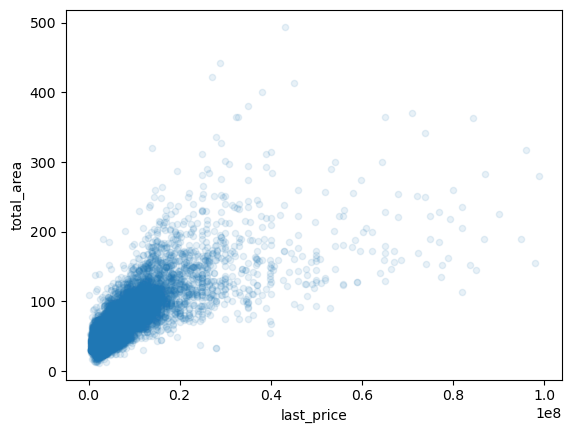

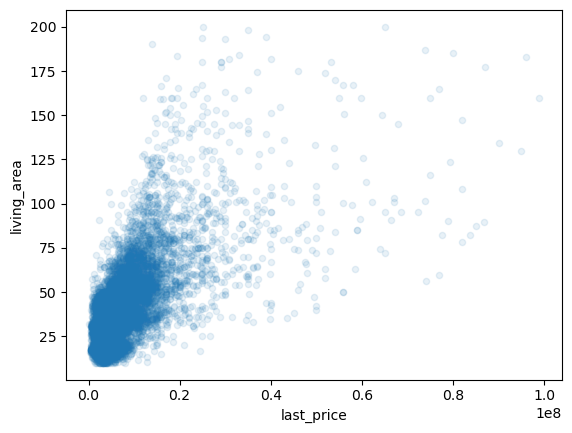

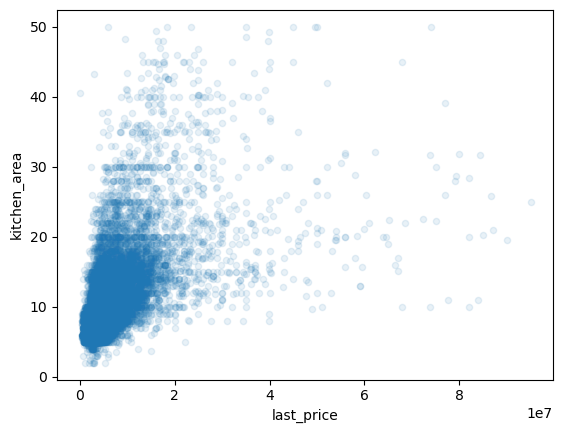

In [91]:
df.plot(x='last_price', y='total_area', kind='scatter', alpha=0.1)
df.plot(x='last_price', y='living_area', kind='scatter', alpha=0.1)
df.plot(x='last_price', y='kitchen_area', kind='scatter', alpha=0.1)
plt.show()

<AxesSubplot:xlabel='rooms'>

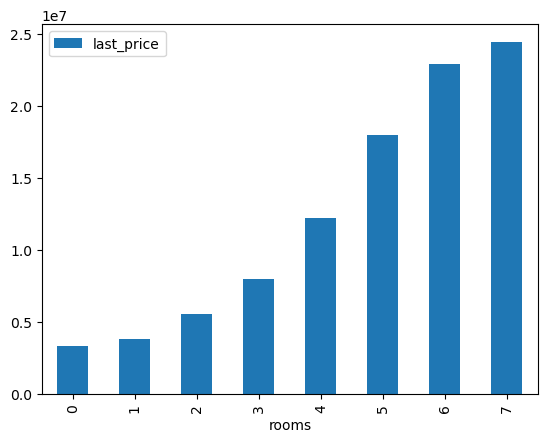

In [92]:
df.pivot_table(index='rooms',values='last_price').plot(y='last_price', kind='bar')

<AxesSubplot:title={'center':'median'}, xlabel='dayofweek'>

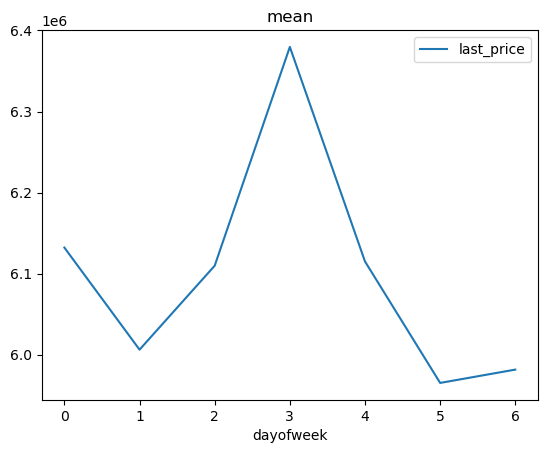

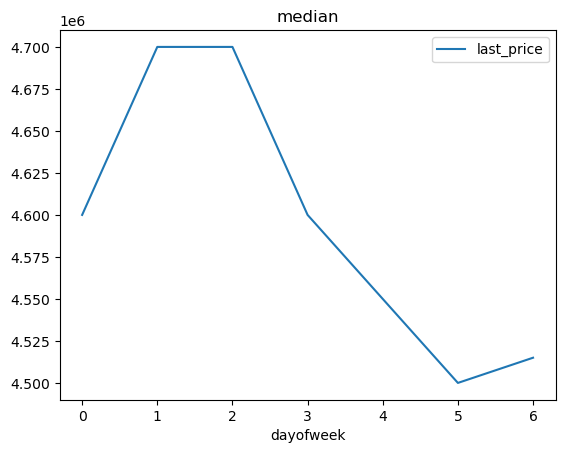

In [93]:
df.pivot_table(index='dayofweek',values='last_price',aggfunc='mean').plot(y='last_price', kind='line', title='mean')
df.pivot_table(index='dayofweek',values='last_price',aggfunc='median').plot(y='last_price', kind='line', title='median')

<AxesSubplot:title={'center':'median'}, xlabel='month'>

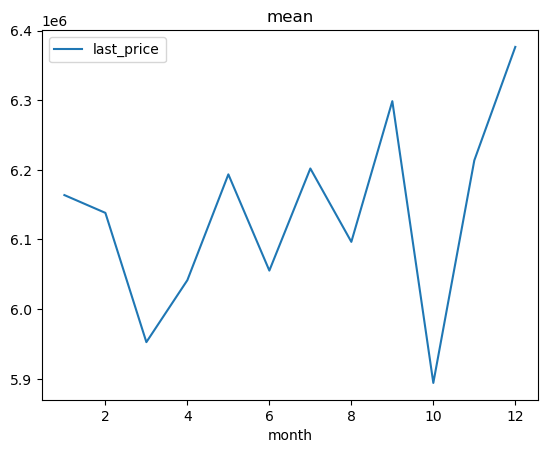

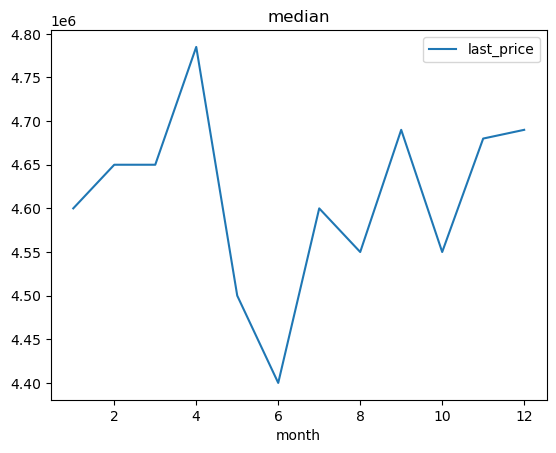

In [94]:
df.pivot_table(index='month',values='last_price',aggfunc='mean').plot(y='last_price', kind='line', title='mean')
df.pivot_table(index='month',values='last_price',aggfunc='median').plot(y='last_price', kind='line', title='median')

<AxesSubplot:title={'center':'median'}, xlabel='year'>

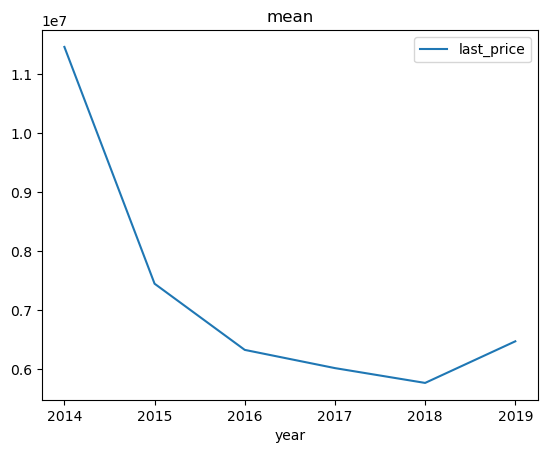

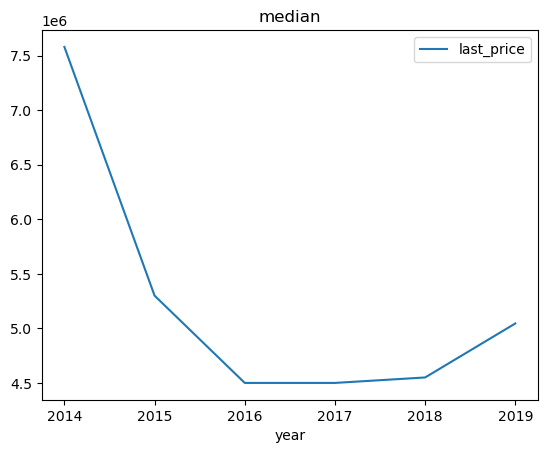

In [95]:
df.pivot_table(index='year',values='last_price',aggfunc='mean').plot(y='last_price', kind='line', title='mean')
df.pivot_table(index='year',values='last_price',aggfunc='median').plot(y='last_price', kind='line', title='median')

**Вывод**
<br />
- Комнаты. Самые дорогие квартиры - квартиры с 6-7 комнатами.
- Дни недели. Самые высокие цена на квартиры в середине неделе, а именно в среду и в четверг.
- Месяцы. На графике видно в какие месяцы цена на квартиры наименьшая. Это 4-6 месяц. Скачки мы можем наблюдать на 9 месяце.
- Год. Цена на квартиры снижалась с 2014 года по 2016. После 2016 года мы видим положительный тренд роста цен квартир.

<AxesSubplot:title={'center':'median'}, xlabel='total_area'>

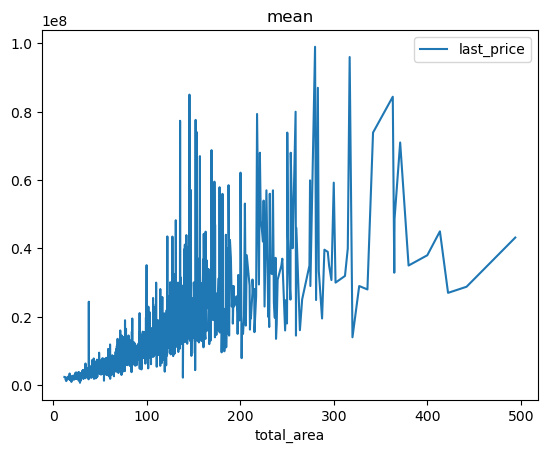

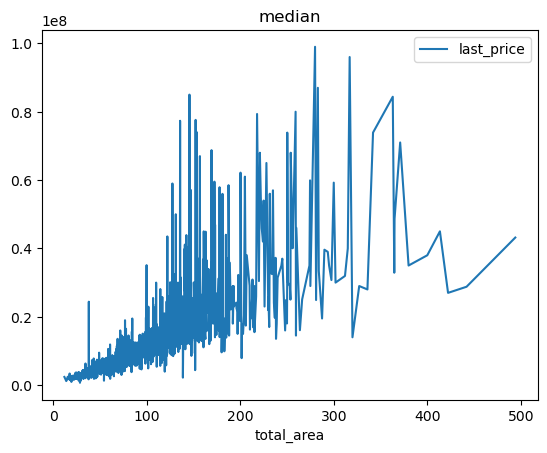

In [96]:
df.pivot_table(index='total_area',values='last_price',aggfunc='mean').plot(y='last_price', kind='line', title='mean')
df.pivot_table(index='total_area',values='last_price',aggfunc='median').plot(y='last_price', kind='line', title='median')

Из-за большого количества квартир график получился очень шумный, но мы можем заметить тендецию, что чем больше площадь квартиры, тем выше ее цена

Цена по убыванию зависит от:

- общей площади
- жилой площади
- площади кухни
- количества комнат.

Цена практически на зависит от:

- этажа, на котором расположена квартира
- даты размещения.

<AxesSubplot:xlabel='last_price', ylabel='floor_category'>

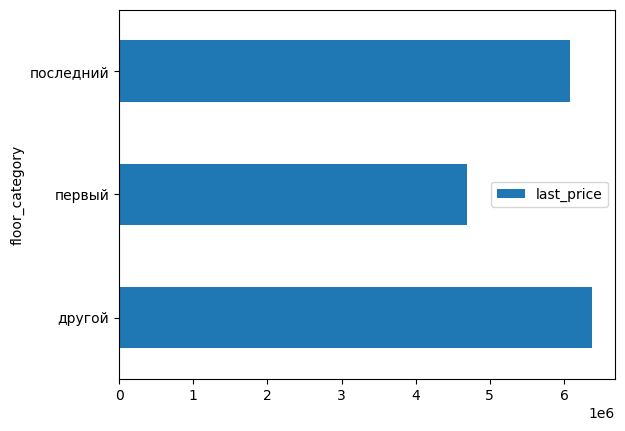

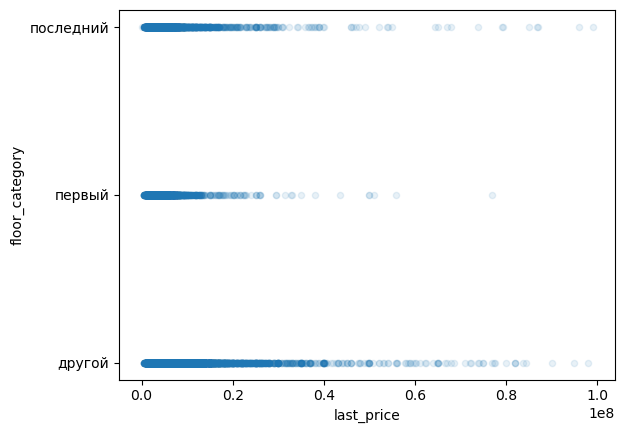

In [97]:
df.pivot_table(index='floor_category',values='last_price').plot(y='last_price', kind='barh');
df.plot(x='last_price', y='floor_category', kind='scatter', alpha=0.1)

**Средняя цена одного квадратного метра в топ 10 пунктах**

<AxesSubplot:ylabel='locality_name'>

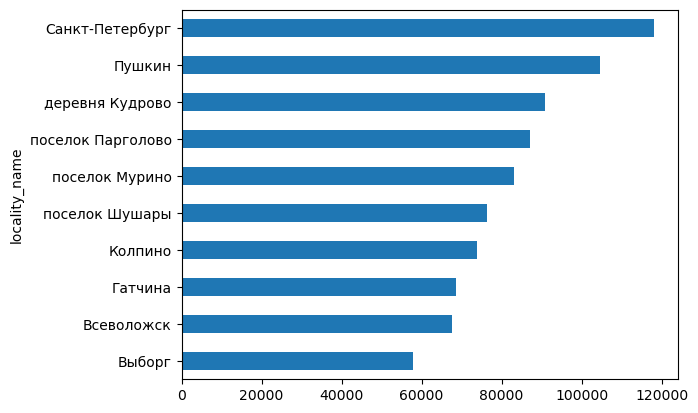

In [98]:
top_10 = df.pivot_table(index='locality_name', values=['last_price','total_area'] ,aggfunc=['sum','count'])
top_10.columns=['last_price_sum','total_area_sum','last_price_count','total_area_count']
top_10.pop('total_area_count')
top_10.sort_values(by=['last_price_count'],ascending=False, inplace=True)
top_10 = top_10.iloc[:10]
top_10['price_per_sq_m'] = top_10['last_price_sum']/top_10['total_area_sum']
top_10.sort_values(by=['price_per_sq_m'],ascending=True, inplace=True)
top_10['price_per_sq_m'].plot(kind='barh')

In [99]:
df.groupby('locality_name').agg({'balcony':'count', 'last_price':'median'}) \
    .sort_values(by = 'balcony', ascending = False) \
    .head(10)

,balcony,last_price
locality_name,,
Санкт-Петербург,15542,5500000.0
поселок Мурино,555,3400000.0
поселок Шушары,439,3950000.0
Всеволожск,396,3465000.0
Пушкин,364,5150000.0
Колпино,337,3600000.0
поселок Парголово,327,4100000.0
Гатчина,307,3100000.0
деревня Кудрово,299,3790000.0


Как и ожидалось самые дорогие квартиры в Санкт-Петербурге.

In [100]:
df.groupby(by='rooms')['rooms'].count().sort_values(ascending=False)

rooms
1    8012
2    7913
3    5773
4    1158
5     306
0     194
6      95
7      44
Name: rooms, dtype: int64

Ожидаемо самая дорогая недвижимость в Санкт-Петербурге.
В ТОП-10 входят ближайшие к Санкт-Петербургу города.

In [101]:
df.query('locality_name == "санкт-петербург"')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,floor_category,price_per_sqm,dayofweek,month,year,citycenters_nearest_km


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23495 entries, 0 to 23494
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            23495 non-null  int64         
 1   last_price              23495 non-null  int32         
 2   total_area              23495 non-null  float64       
 3   first_day_exposition    23495 non-null  datetime64[ns]
 4   rooms                   23495 non-null  int64         
 5   ceiling_height          14342 non-null  float64       
 6   floors_total            23409 non-null  Int8          
 7   living_area             21607 non-null  float64       
 8   floor                   23495 non-null  int64         
 9   is_apartment            23495 non-null  bool          
 10  studio                  23495 non-null  bool          
 11  open_plan               23495 non-null  bool          
 12  kitchen_area            21240 non-null  float6

<AxesSubplot:title={'center':'Санкт-Петербург'}, xlabel='citycenters_nearest_km'>

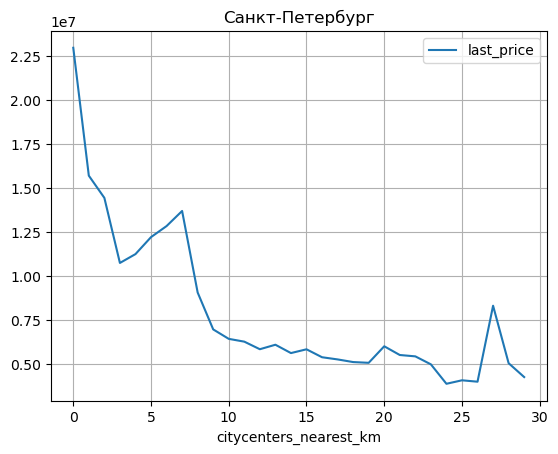

In [103]:

spb = df[['last_price','citycenters_nearest_km','locality_name']]
spb.query('locality_name == "Санкт-Петербург"').pivot_table(index='citycenters_nearest_km',values='last_price',aggfunc='mean')\
    .plot(title='Санкт-Петербург', grid = True)

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23495 entries, 0 to 23494
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            23495 non-null  int64         
 1   last_price              23495 non-null  int32         
 2   total_area              23495 non-null  float64       
 3   first_day_exposition    23495 non-null  datetime64[ns]
 4   rooms                   23495 non-null  int64         
 5   ceiling_height          14342 non-null  float64       
 6   floors_total            23409 non-null  Int8          
 7   living_area             21607 non-null  float64       
 8   floor                   23495 non-null  int64         
 9   is_apartment            23495 non-null  bool          
 10  studio                  23495 non-null  bool          
 11  open_plan               23495 non-null  bool          
 12  kitchen_area            21240 non-null  float6

С большим отрывом лидирует недвижимость до 1км.
Видим более низкие цены на недвижимость на расстоянии от 1 км. до 7 км. включительно.
Далее цена спадает на расстоянии от 8 км. до 27 км.
Видим пик на 27км, его сложно объяснить, возможно это недвижимость в "особом" районе.

### Общий вывод

После изучения данных можно сказать, что можно работать с таблицами, в которых встречаются пропущенные значения. Данные всё-таки лучше очищать от явных "выбросов", но возможно чистить данные придётся после этапа исследовательского анализа данных. В нашем примере - это дорогие квартиры, которые портили корреляции и графики зависимости полной стоимости от разных параметров. Из необычных особенностей:

В 27 км от центра Санкт-Петербурга есть недвижимость по цене почти равная недвижимости в 8 км. от центра;
В ТОП-10 входят в основном ближайшие к Санкт-Петербургу города и самые крупные города области:
- Пушкин;
- Гатчина;
- Всеволожск;
- Выборг.
Цена в основном зависит от площади квартиры, но корреляция с этажностью(не первый и не последний) видна на графике.
Таких квартир явно больше и они явно дороже.
Быстрые продажи это до 45 дней, а необычно долгие - свыше 183 дней.
Выбросы Количество объявлений, которые сняты через:
- 45 дней: 613
- 60 дней: 428
- 90 дней: 179
Предполагаю, что данные взяты с площадки, где неактивные объявления автоматически снимаются, если пользователь не продлит время размещения через определёный срок. Либо присутсвует платное рамещение. Нужно связаться с тем, кто предоставляет данные.

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [ ]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [ ]  определены пропущенные значения
- [ ]  заполнены пропущенные значения там, где это возможно
- [ ]  есть пояснение, какие пропущенные значения обнаружены
- [ ]  изменены типы данных
- [ ]  есть пояснение, в каких столбцах изменены типы и почему
- [ ]  устранены неявные дубликаты в названиях населённых пунктов
- [ ]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [ ]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [ ]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [ ]  посчитано и добавлено в таблицу: месяц публикации объявления
- [ ]  посчитано и добавлено в таблицу: год публикации объявления
- [ ]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [ ]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [ ]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [ ]  построены гистограммы для каждого параметра
- [ ]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [ ]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [ ]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [ ]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [ ]  в каждом этапе есть промежуточные выводы
- [ ]  есть общий вывод